In [1]:
import numpy as np
import numbers
from collections import OrderedDict
import torch
import torch.nn as nn
import math
from tqdm import tqdm

In [2]:
def Test_Depth_vs_Lamnbda(nb_avg=20, p=100,n=500, intern_dim= 10, epochs = 2000, untilConv = -1, depthArray = np.array([-1,0,1,4,8,10]), LambdaArray = np.logspace(0,2,100)):

    errorArray = np.zeros((nb_avg,depthArray.shape[0],2))
    modelErrorArray = np.zeros((nb_avg,depthArray.shape[0],epochs))
    MvsR_ErrorArray = np.zeros((nb_avg,depthArray.shape[0],LambdaArray.shape[0]))
    for f in tqdm(range(nb_avg)):
        
        A,b = Generate_data(p=p, n=n)
        ridgeErrorArray = Ridge_Lambda_Compute(A,b,LambdaArray)
        
        for i in range(depthArray.shape[0]):
            model = MultiLayerPerceptron(input_dim=p,
                                         intern_dim=intern_dim,
                                         output_dim=1,
                                         depth=depthArray[i],
                                         isBiased = False)
            error,e = train(model, torch.from_numpy(A).to(torch.float32), torch.from_numpy(b).to(torch.float32), untilConv = untilConv, save = False, epochs = epochs)
            modelErrorArray[f,i] = error
            errorArray[f,i] = [model.depth,error[e]]

            MvsR_ErrorArray[f,i] = (errorArray[f,i,1] - ridgeErrorArray[:,1])
    
    mean_errorArray = np.mean(MvsR_ErrorArray, axis=0)
    mean_modelErrorArray = np.mean(modelErrorArray, axis=0)
    
    #plot_MvsR_overLambda(mean_errorArray, ridgeErrorArray)
    plot_MultiGraph(mean_errorArray,LambdaArray,depthArray)
    plot_M_overStep(mean_modelErrorArray,depthArray)

In [23]:
def Test_Ndata_vs_Lamnbda(nb_avg=10, p=100,depth=1, intern_dim= 10, epochs = 2000, untilConv = -1, NDataArray = np.array([100,500,2000,10000]), LambdaArray = np.logspace(0,2,100)):

    errorArray = np.zeros((nb_avg,NDataArray.shape[0],2))
    modelErrorArray = np.zeros((nb_avg,NDataArray.shape[0],epochs))
    MvsR_ErrorArray = np.zeros((nb_avg,NDataArray.shape[0],LambdaArray.shape[0]))

    for f in tqdm(range(nb_avg)):
        for i in range(NDataArray.shape[0]):
            A,b = Generate_data(p=p, n=NDataArray[i])
            ridgeErrorArray = Ridge_Lambda_Compute(A,b,LambdaArray)
            model = MultiLayerPerceptron(input_dim=p,
                                         intern_dim=intern_dim,
                                         output_dim=1,
                                         depth=depth,
                                         isBiased = True)
            error,e = train(model, torch.from_numpy(A).to(torch.float32), torch.from_numpy(b).to(torch.float32), untilConv = untilConv, save = False, epochs = epochs)
            modelErrorArray[f,i] = error
            errorArray[f,i] = [model.depth,error[e]]
    
            MvsR_ErrorArray[f,i] = (-errorArray[f,i,1] + ridgeErrorArray[:,1])
    
    mean_errorArray = np.mean(MvsR_ErrorArray, axis=0)
    mean_modelErrorArray = np.mean(modelErrorArray, axis=0)
    return mean_errorArray, mean_modelErrorArray


100%|██████████| 10/10 [01:09<00:00,  6.92s/it]


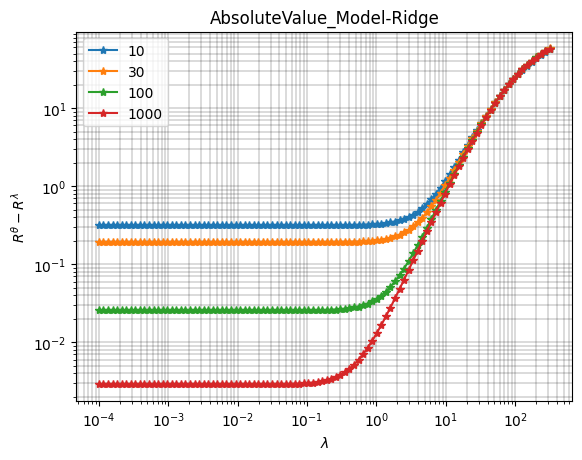

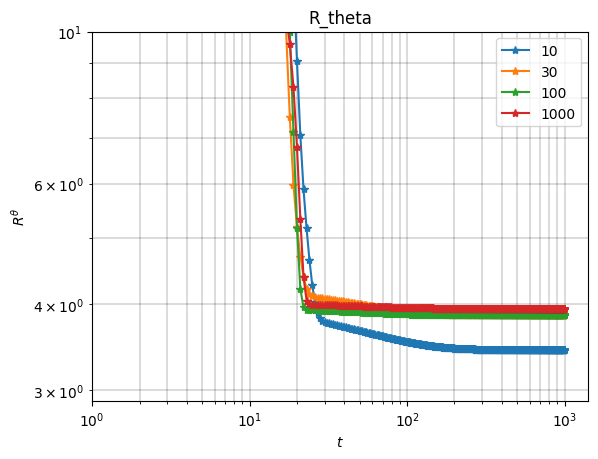

In [28]:
%run utils.py
%run Plot_lib.ipynb
LambdaArray = np.logspace(-4,2.5,100)
NDataArray = np.array([10,30,100,1000])

mean_errorArray, mean_modelErrorArray = Test_Ndata_vs_Lamnbda(nb_avg=10,epochs = 1000, depth =2,NDataArray = NDataArray, LambdaArray = LambdaArray)
#Test_Depth_vs_Lamnbda(nb_avg=10, epochs = 1000, n =10000,depthArray = np.array([-1,0,1,4,5,6,7,8]), LambdaArray = np.logspace(-4,4,100))

plot_MultiGraph(mean_errorArray,LambdaArray,NDataArray, title = "AbsoluteValue_Model-Ridge")
plot_M_overStep(mean_modelErrorArray,NDataArray)

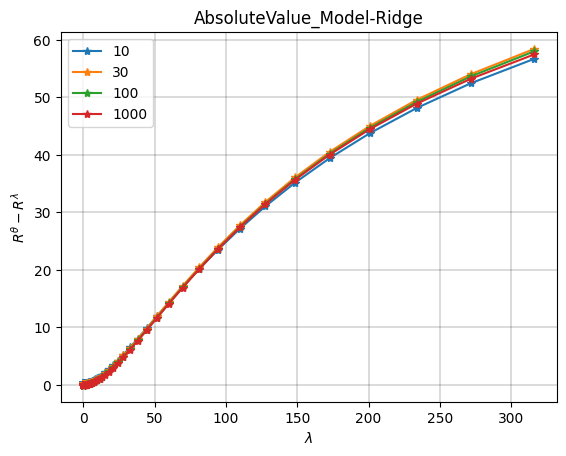

In [32]:
def plot_MultiGraph(modelErrorArray,X,modelName, title = ""):
    fig1,ax1 = plt.subplots(1,1)
    for l in range(modelErrorArray.shape[0]):
        ax1.plot(X, modelErrorArray[l], label = modelName[l] , marker='*')
    ax1.set_title(title)
    ax1.set_xlabel(r'$\lambda$')
    ax1.set_ylabel(r'$R^\theta - R^\lambda$')
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')
    plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
    plt.legend()
    plt.savefig(f'figures/excess_risk_{str(title)}_Lambda{str(modelErrorArray.shape[0])}')

plot_MultiGraph(abs(mean_errorArray),LambdaArray,NDataArray, title = "AbsoluteValue_Model-Ridge")